# Pair Trading of GLD and GDX

In [1]:
import nbconvert

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import statsmodels.api as sm

In [6]:
#read in GLD file
filepath = 'C:\\Users\\rhyth\\OneDrive\\Desktop\\Trading\\Python codes\\GLD.xls'
df1=pd.read_excel(filepath)

In [7]:
#read in GDX file
filepath = "C:\\Users\\rhyth\\OneDrive\\Desktop\\Trading\\Python codes\\GDX.xls"
df2=pd.read_excel(filepath)

In [8]:
#merge the two data frames together into one dataframe on their common Date column
df=pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))

In [9]:
#sets the date as the new index, modifies the original df
df.set_index('Date', inplace=True)

In [10]:
#sort the df, assending order by default
df.sort_index(inplace=True)

In [11]:
#creates a numpy array of integers from 0 to 251, these indicies will be for the training (developing set)
trainset=np.arange(0, 252)

In [12]:
#creates a numpy array of integers starting from the length of train set (252) and ending one less than the number of rows in df. These indicies will be for the testing set
testset=np.arange(trainset.shape[0], df.shape[0])

## Determine hedge ratio on trainset

In [13]:
#sets up an ordinary least squares regression model to see the linear relationship between GLD and GDX.. Specifically how movement in GDX affects GLD.
#CONSIDER AN INTERCEPT. DO I NEED ONE OR NOT? No intercept means regresion line goes through the origin
model=sm.OLS(df.loc[:, 'Adj Close_GLD'].iloc[trainset], df.loc[:, 'Adj Close_GDX'].iloc[trainset])

In [14]:
#this actually fits the data to the model for quant analysis
results=model.fit()

In [15]:
#extracts the regression coefficient from the fitted model. In this case it represents how much GLD (dependent) moves in response to GLX (independednt) 
#usually the 0 index element is the intercept while the 1 index element is the slope
#slope is the regression coefficient
hedgeRatio=results.params

In [16]:
#this value means that for every 1 unit increase in the price of GDX, GLD is expected to increase by approx 1.631 units (assuming all other factors are held constant)
#For instance, if your analysis indicates that GLD is undervalued relative to GDX, you might buy GLD and sell 1.631 units of GDX for each unit of GLD you bought.
hedgeRatio

Adj Close_GDX    1.631009
dtype: float64

to calulate the spread (difference in price, in this case weighted by the hedge ratio) use: 
spread = GLD - hedgeRatio * GLX

In [17]:
#calculates the spread of GLD and GDX using the adjusted closing price
#since the above model does not have an intercept than the 0 index element is the regression coefficient
spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']

C:\Users\rhyth\AppData\Local\Temp\ipykernel_57312\3022565969.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread=df.loc[:, 'Adj Close_GLD']-hedgeRatio[0]*df.loc[:, 'Adj Close_GDX']


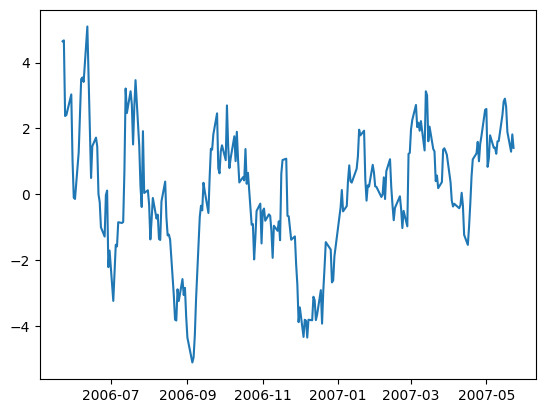

In [18]:
#plots the spread only over thr training set period
plt.plot(spread.iloc[trainset])

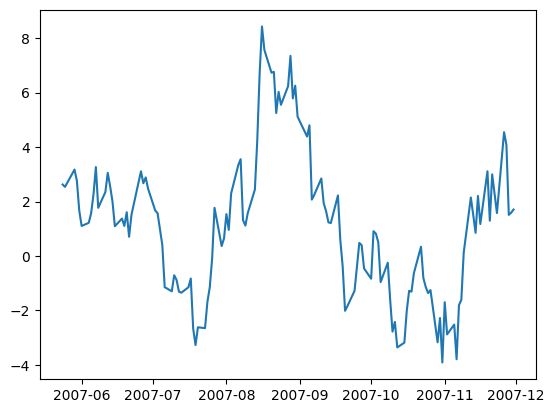

In [19]:
#plots the spread over thr test set period
plt.plot(spread.iloc[testset])

In [20]:
#calculates the expected value (mean) of the spread over the training set period
spreadMean=np.mean(spread.iloc[trainset])

In [21]:
spreadMean

0.05219623850040229

In [22]:
spreadStd=np.std(spread.iloc[trainset])

In [23]:
spreadStd

1.944860873496508

In [24]:
df['zscore']=(spread-spreadMean)/spreadStd

In [25]:
df['positions_GLD_Long']=0

In [26]:
df['positions_GDX_Long']=0

In [27]:
df['positions_GLD_Short']=0

In [28]:
df['positions_GDX_Short']=0

In [29]:
df.loc[df.zscore>=2, ('positions_GLD_Short', 'positions_GDX_Short')]=[-1, 1] # Short spread

In [30]:
df.loc[df.zscore<=-2, ('positions_GLD_Long', 'positions_GDX_Long')]=[1, -1] # Buy spread

In [31]:
df.loc[df.zscore<=1, ('positions_GLD_Short', 'positions_GDX_Short')]=0 # Exit short spread

In [32]:
df.loc[df.zscore>=-1, ('positions_GLD_Long', 'positions_GDX_Long')]=0 # Exit long spread

In [33]:
df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

C:\Users\rhyth\AppData\Local\Temp\ipykernel_57312\3027636567.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal


In [34]:
positions_Long=df.loc[:, ('positions_GLD_Long', 'positions_GDX_Long')]

In [35]:
positions_Short=df.loc[:, ('positions_GLD_Short', 'positions_GDX_Short')]

In [36]:
positions=np.array(positions_Long)+np.array(positions_Short)

In [37]:
positions=pd.DataFrame(positions)

In [38]:
dailyret=df.loc[:, ('Adj Close_GLD', 'Adj Close_GDX')].pct_change()

In [39]:
pnl=(np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

In [40]:
sharpeTrainset=np.sqrt(252)*np.mean(pnl[trainset[1:]])/np.std(pnl[trainset[1:]])

In [41]:
sharpeTrainset

1.9182982282569077

In [42]:
sharpeTestset=np.sqrt(252)*np.mean(pnl[testset])/np.std(pnl[testset])

In [43]:
sharpeTestset

1.494313761833427

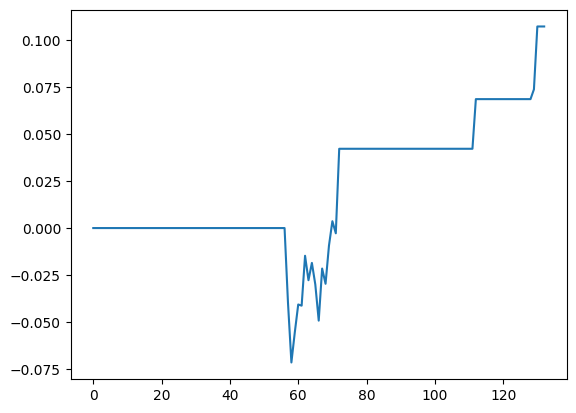

In [44]:
plt.plot(np.cumsum(pnl[testset]))

In [45]:
positions.to_pickle('example3_6_positions')